In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

In [2]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=1/6)

In [24]:
from sklearn.cluster import KMeans

clf = KMeans(10)
y_pred = clf.fit_predict(X_tsne)

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y.astype(np.int32), y_pred)
clust_map = [-1] * 10
for i in range(len(conf_mat)):
  j = np.argmax(conf_mat[i])
  clust_map[j] = i

In [21]:
from sklearn.base import TransformerMixin

class ClusterMap(TransformerMixin):
  def __init__(self):
    return
  
  def fit(self, y_pred, y):
    conf_mat = confusion_matrix(y.astype(np.int32), y_pred)
    clust_map = [-1] * 10
    for i in range(len(conf_mat)):
      j = np.argmax(conf_mat[i])
      clust_map[j] = i
    self.clust_map = clust_map
  
  def transform(self, y_pred):
    transformer = np.vectorize(lambda y : self.clust_map[y])
    return transformer(y_pred)

In [28]:
y_pred = clf.predict(X_tsne)

clust_map = ClusterMap()
clust_map.fit(y_pred, y)
y_pred_tran = clust_map.transform(y_pred)
confusion_matrix(y.astype(np.int32), y_pred_tran)

array([[6846,    4,    6,    1,    0,   11,   26,    2,    5,    2],
       [   1, 7440,   15,    3,  274,   99,    5,   15,   20,    5],
       [  45,   53, 6671,   20,    6,    3,   12,   90,   81,    9],
       [   3,   12,   35, 6812,    2,  139,    2,   43,   61,   32],
       [   3,  236,    1,    1, 5960,    0,   27,    8,   46,  542],
       [  38,    7,    1,  124,    3, 6026,   62,    6,   14,   32],
       [  38,   10,    1,    1,    7,   55, 6764,    0,    0,    0],
       [   2,   91,   35,    1,   15,    1,    0, 6938,   28,  182],
       [  16,   68,   13,  231,   17,  517,   31,   15, 5890,   27],
       [  17,   20,    6,   74,   63,   14,    5,  251, 1533, 4975]])

In [32]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y.astype(np.int32), y_pred_tran))

0.9188857142857143


In [33]:
from sklearn.metrics import silhouette_score

print(silhouette_score(X_tsne, y_pred_tran))

0.40201378


In [89]:
import os

from matplotlib.image import imread, imsave
image = imread(os.path.join('..', 'data', 'images', 'block.jpg'))
print(image.shape)

(225, 225, 3)


In [94]:
# color segmentation
X_image = image.reshape(-1, 3)
print(X_image.shape)
kmeans = KMeans(n_clusters=20).fit(X_image)
print(kmeans.cluster_centers_)
segmented_image = kmeans.cluster_centers_[kmeans.labels_]
segmented_image = segmented_image.reshape(image.shape).astype(np.uint8)
imsave(os.path.join('..', 'data', 'images', 'segmented.jpg'), segmented_image)

(50625, 3)
[[123.21114865 180.65793919 180.31418919]
 [254.79584192 254.85189843 254.80809675]
 [242.12621359 172.51699029   4.38228155]
 [230.81424376 122.67988253 124.94419971]
 [154.20142857 202.48785714  52.58714286]
 [ 51.42286751 202.79128857 152.00544465]
 [165.27827502 103.34174125 130.27095199]
 [247.83870968 219.65591398 114.90860215]
 [193.78871795 127.90358974 157.19179487]
 [240.32310838 180.13496933 195.2208589 ]
 [ 71.70121951 149.32113821 181.58130081]
 [155.27833753 206.11586902 205.69017632]
 [253.45630175 203.24287029   3.41306348]
 [ 36.69849246 171.52763819 126.26130653]
 [235.44648318 234.85015291 222.90519878]
 [150.85240964 152.0873494   85.88253012]
 [197.48062016 244.0503876  110.11627907]
 [171.60280374 100.27102804  96.07943925]
 [173.86315789 132.98947368   7.        ]
 [105.79672131 231.3442623  189.15081967]]


In [124]:
# trying instance segmentation

from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler

class InstanceTransformer(TransformerMixin):
  def __init__(self, exponent=1.0):
    self.exponent = exponent
    self.scaler = StandardScaler()
  
  def fit(self, image):
    return self

  def transform(self, image):
    data = []
    scaled_image = image ** self.exponent
    # scaled_image = scaled_image.reshape(-3, 1)
    # scaled_image = self.scaler.fit_transform(scaled_image)
    # scaled_image = scaled_image.reshape(image.shape)
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        data.append(np.concatenate(([i, j], scaled_image[i, j])))
    # return self.scaler.fit_transform(np.array(data))
    return np.array(data)

k = 24
image = imread(os.path.join('..', 'data', 'images', 'flowers.jpg'))
transformer = InstanceTransformer(exponent=1.12)
X_image = transformer.fit_transform(image)
kmeans = KMeans(n_clusters=k).fit(X_image)
segmented_image = kmeans.labels_
color_map = np.array([np.random.rand(3,) * 255 for clusters in range(kmeans.n_clusters)]).astype(np.uint8)
segmented_image = color_map[segmented_image].reshape(image.shape)
imsave(os.path.join('..', 'data', 'images', 'segmented.jpg'), segmented_image)


In [125]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [130]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
print(confusion_matrix(y_test, log_clf.predict(X_test)))
print(accuracy_score(y_test, log_clf.predict(X_test)))

[[50  0  0  0  0  0  0  0  0  0]
 [ 0 49  0  0  0  0  0  0  0  0]
 [ 0  1 47  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  1  0  0  1  0]
 [ 0  1  0  0 39  0  0  0  0  0]
 [ 0  0  1  0  0 34  0  1  0  1]
 [ 0  1  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  1  0  0  1  0  0  0 44  0]
 [ 0  0  0  0  0  1  0  0  2 43]]
0.9711111111111111


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
  ('kmeans', KMeans(n_clusters=100)),
  ('log', LogisticRegression()),
])
pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, pipe.predict(X_test)))
print(accuracy_score(y_test, pipe.predict(X_test)))

[[49  0  0  0  1  0  0  0  0  0]
 [ 0 47  0  0  1  0  1  0  0  0]
 [ 0  0 48  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  1  0  1  0  0]
 [ 1  0  0  0 39  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  0  0  0  1  1  0  0 44  0]
 [ 0  0  0  2  0  1  0  0  0 43]]
0.9755555555555555


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [153]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'kmeans__n_clusters': np.linspace(50, 200, 100, dtype=np.int32)
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'kmeans__n_clusters': 183}


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [157]:
pipe = Pipeline([
  ('kmeans', KMeans(n_clusters=183)),
  ('log', LogisticRegression()),
])
pipe.fit(X_train, y_train)
print(confusion_matrix(y_test, pipe.predict(X_test)))
print(accuracy_score(y_test, pipe.predict(X_test)))

[[49  0  0  0  1  0  0  0  0  0]
 [ 0 46  0  0  1  0  1  0  0  1]
 [ 0  0 48  0  0  0  0  0  0  0]
 [ 0  0  0 40  0  1  0  1  0  0]
 [ 1  0  0  0 39  0  0  0  0  0]
 [ 1  0  1  0  0 35  0  0  0  0]
 [ 0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  0]
 [ 0  0  0  0  2  1  0  0 43  0]
 [ 0  0  0  2  0  2  0  0  0 42]]
0.9644444444444444


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [165]:
k = 50
kmeans = KMeans(n_clusters=k)
X_clstr = kmeans.fit_transform(X_train)
print(X_clstr)

[[53.92922316 43.24348718 48.07500093 ... 38.28053429 36.13426519
  58.57900648]
 [47.89427013 38.04282227 46.43896147 ... 36.8621211  42.95459097
  49.82971001]
 [46.25322812 35.40055344 50.92128379 ... 40.38542607 40.31978573
  52.51031645]
 ...
 [56.00322411 45.60982708 53.69469248 ... 44.89969531 38.80391661
  55.43314291]
 [48.41860294 41.36457125 49.63702535 ... 21.6039959  36.96790902
  53.25254298]
 [51.40390171 32.00579029 42.42277017 ... 33.27385318 42.80437516
  36.40512784]]


In [199]:
print(X_train.shape, X_clstr.shape)
X_train_idx = np.argmin(X_clstr, axis=0)
X_train_rep = X_train[X_train_idx]
y_train_rep = y_train[X_train_idx]
print(X_train_rep.shape)
print(y_train_rep.shape)
p = 0.8
X_clstr_dist = np.min(X_clstr, axis=1)
X_clstr_dist_idx = np.argsort(X_clstr_dist)
X_train_top_p = X_train[X_clstr_dist_idx][:int(len(X_clstr_dist) * p)]
y_train_top_p = y_train[X_clstr_dist_idx][:int(len(X_clstr_dist) * p)]
print(X_train_top_p)
print(X_train_top_p.shape)
print(y_train_top_p.shape)
# print(X_clstr[X_clstr_dist_idx])
# targets = y_train_rep[kmeans.labels_]
# print(targets.shape)

(1347, 64) (1347, 50)
(50, 64)
(50,)
[[ 0.  0.  0. ...  2.  0.  0.]
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  6. ...  3.  0.  0.]
 ...
 [ 0.  0.  1. ... 12.  1.  0.]
 [ 0.  1.  8. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(1077, 64)
(1077,)


In [200]:
log = LogisticRegression()
log.fit(X_train_rep, y_train_rep)
print(accuracy_score(y_test, log.predict(X_test)))
log.fit(X_train_top_p, y_train_top_p)
print(accuracy_score(y_test, log.predict(X_test)))

0.9177777777777778
0.9511111111111111


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [235]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.12, min_samples=5)
dbscan.fit(X)
X_anomolies = X[np.where(dbscan.labels_==-1)]
print('clusters', np.unique(dbscan.labels_))
print(X_anomolies.shape)
print(100 * len(X_anomolies) / len(X))

clusters [-1  0  1]
(2, 2)
0.2


In [279]:
from sklearn.datasets import load_digits

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target'].values

In [280]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

(70000, 154)


In [281]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, n_init=1)
gmm.fit(X_train[:10000])
print(gmm.predict_proba(X_test))

[[0.00000000e+000 5.37848097e-169 9.99999999e-001 ... 8.00423484e-010
  0.00000000e+000 0.00000000e+000]
 [1.00000000e+000 5.15699510e-160 0.00000000e+000 ... 0.00000000e+000
  2.25801615e-038 0.00000000e+000]
 [1.00000000e+000 4.92914857e-143 0.00000000e+000 ... 7.23069055e-117
  1.24999349e-158 0.00000000e+000]
 ...
 [0.00000000e+000 3.37119477e-135 0.00000000e+000 ... 0.00000000e+000
  1.00000000e+000 2.64772344e-189]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 5.98156095e-037]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [282]:
train_probs = gmm.predict_proba(X_train[:10000])
preds = gmm.predict(X_train[:10000])
rep_idx = np.argmax(train_probs, axis=0)
print(rep_idx)
print(preds[rep_idx])
print(y_train[:11])

digit_map = y_train[rep_idx]
print(digit_map)

[ 9  5  3 36  2 10  7  1 12  0]
[0 1 2 3 4 5 6 7 8 9]
['4', '5', '7', '0', '5', ..., '0', '5', '2', '1', '6']
Length: 11
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']
['1', '2', '0', '7', '7', '6', '5', '5', '1', '4']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


In [283]:
from sklearn.metrics import confusion_matrix

pred = digit_map[gmm.predict(X_test)]
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[1015    0   24    0    2  221    2   84    0    0]
 [   0 1434   26    0    8   70    4   60    0    0]
 [   0    0 1161    0   28  108    2   30    0    0]
 [   2    7  108    0   23  909    1  391    0    0]
 [   1    3   33    0  766  435    2  138    0    0]
 [   1    1   20    0   14  878   13  377    0    0]
 [   5   10   15    0    9   89 1246   39    0    0]
 [   0    2    2    0  286  239    0  904    0    0]
 [   0   15   11    0   26  544    2  773    0    0]
 [   0    0    3    0  484  134    0  760    0    0]]
0.5288571428571428


In [323]:
from sklearn.datasets import fetch_olivetti_faces

X, y = fetch_olivetti_faces(return_X_y=True)
print(X.shape, y.shape)

(400, 4096) (400,)


In [333]:
for i in range(len(X)):
  imsave(os.path.join('..', 'data', 'images', 'olivetti', str(i) + '.jpg'), X[i].reshape(64, 64))

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

In [327]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.cluster import KMeans

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

stcv = StratifiedShuffleSplit(n_splits=3, test_size=0.2)

max_val = 0
max_k = -1
for k in range(2, 16):
  for train_idx, test_idx in stcv.split(X_train, y_train):
    X_train_sh, X_val, y_train_sh, y_val = X_train[train_idx], X_train[test_idx], y_train[train_idx], y_train[test_idx]
    # print(X_train_sh)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_sh)
    score = silhouette_score(X_val, kmeans.predict(X_val))
    if score > max_val:
      max_val = score
      max_k = k
    print(k, score)
print('maxes', max_k, max_val)


(400, 123)
2 0.13187912
2 0.15183888
2 0.16189298
3 0.11342488
3 0.117081195
3 0.123464406
4 0.12278497
4 0.084962815
4 0.091879204
5 0.07783991
5 0.09900117
5 0.09788102
6 0.058344185
6 0.080292344
6 0.09087488
7 0.08129243
7 0.059225522
7 0.06864467
8 0.06842748
8 0.070650324
8 0.040586658
9 0.07473404
9 0.07493457
9 0.07617386
10 0.06980076
10 0.065760225
10 0.08804537
11 0.07728811
11 0.04272223
11 0.053866662
12 0.08799277
12 0.04852137
12 0.05352864
13 0.043890446
13 0.058780387
13 0.049025625
14 0.056793176
14 0.048192922
14 0.06742495
15 0.057183646
15 0.05816137
15 0.054806586
maxes 2 0.16189298


/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/carlschader/programming/ml-tensorflow/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(400, 2)


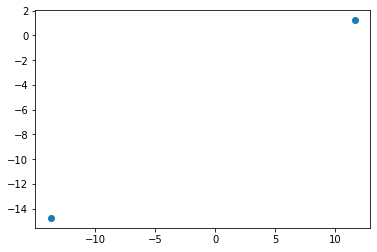

In [328]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(X)
print(X_tsne.shape)
plt.scatter(X_tsne[0], X_tsne[1])
plt.show()

In [343]:
# kmeans = KMeans(n_clusters=max_k)
# kmeans.fit(X_pca)
# print(kmeans.labels_.shape)
# idx_0 = np.argwhere(kmeans.labels_ == 0).ravel()
# idx_1 = np.argwhere(kmeans.labels_ == 1).ravel()

# idx_larger = (idx_0, idx_1)[np.argmax((len(idx_0), len(idx_1)))]

# X_larger = X_pca[idx_larger]
# y_larger = y[idx_larger]
# print(X_larger.shape)
# print(y_larger.shape)


(400,)
(278, 123)
(278,)


In [345]:
# X_train, X_test, y_train, y_test = train_test_split(X_larger, y_larger, test_size=0.2)

# stcv = StratifiedShuffleSplit(n_splits=3, test_size=0.2)

# max_val = 0
# max_k = -1
# for k in range(2, 40):
#   for train_idx, test_idx in stcv.split(X_train, y_train):
#     X_train_sh, X_val, y_train_sh, y_val = X_train[train_idx], X_train[test_idx], y_train[train_idx], y_train[test_idx]
#     # print(X_train_sh)
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X_train_sh)
#     score = silhouette_score(X_val, kmeans.predict(X_val))
#     if score > max_val:
#       max_val = score
#       max_k = k
#     print(k, score)
# print('maxes', max_k, max_val)

2 0.123899534
2 0.15408504
2 0.1025999
3 0.058238268
3 0.07188446
3 0.08175754
4 0.07279028
4 0.0903024
4 0.0835404
5 0.06474417
5 0.06963597
5 0.06096717
6 0.05234801
6 0.086340494
6 0.053327356
7 0.033335034
7 0.047362253
7 0.061207846
8 0.036377992
8 0.034086306
8 0.039964784
9 0.060030144
9 0.036938988
9 0.030355886
10 0.059906982
10 0.033263154
10 0.062450536
11 0.07729762
11 0.056123592
11 0.08157871
12 0.041580025
12 0.029442279
12 0.041037794
13 0.01669528
13 0.053008832
13 0.06461447
14 0.049723875
14 -0.0018824332
14 0.042005427
15 0.046652757
15 0.03062468
15 0.03264197
16 0.01971201
16 0.049969144
16 0.055462778
17 0.06388729
17 0.07248143
17 0.030823156
18 0.05247833
18 0.080478445
18 0.08941342
19 0.09151049
19 0.050958317
19 0.08035489
20 0.017225897
20 0.037448116
20 0.037244823
21 0.023725295
21 0.048889954
21 0.045881018
22 0.05700099
22 0.06829789
22 0.041575074
23 0.03141547
23 0.08193405
23 -0.008602966
24 0.09802549
24 0.05627673
24 0.075670935
25 0.040969294
25 0

In [364]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# clf = Pipeline([
#   ('pca', PCA(n_components=0.95)),
#   ('pca', PCA(n_components=0.95)),
# ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# softmax = LogisticRegression(multi_class='multinomial')
softmax = DecisionTreeClassifier()
softmax.fit(X_train, y_train)
pred = softmax.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

[[0 0 0 ... 0 0 0]
 [0 2 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 1]]
0.475


In [365]:
from sklearn.model_selection import GridSearchCV

clf = Pipeline([
  ('kmeans', KMeans()),
  ('softmax', DecisionTreeClassifier()),
])

param_grid = {
  'kmeans__n_clusters': np.linspace(150, 200, 10, dtype=np.int32),
}

cv = GridSearchCV(clf, cv=3, param_grid=param_grid, scoring='accuracy', verbose=10)
cv.fit(X_train, y_train)
print(cv.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START kmeans__n_clusters=150.....................................
[CV 1/3; 1/10] END ......kmeans__n_clusters=150;, score=0.551 total time=   8.8s
[CV 2/3; 1/10] START kmeans__n_clusters=150.....................................
[CV 2/3; 1/10] END ......kmeans__n_clusters=150;, score=0.589 total time=   6.2s
[CV 3/3; 1/10] START kmeans__n_clusters=150.....................................
[CV 3/3; 1/10] END ......kmeans__n_clusters=150;, score=0.575 total time=   5.2s
[CV 1/3; 2/10] START kmeans__n_clusters=155.....................................
[CV 1/3; 2/10] END ......kmeans__n_clusters=155;, score=0.533 total time=   5.5s
[CV 2/3; 2/10] START kmeans__n_clusters=155.....................................
[CV 2/3; 2/10] END ......kmeans__n_clusters=155;, score=0.626 total time=   5.4s
[CV 3/3; 2/10] START kmeans__n_clusters=155.....................................
[CV 3/3; 2/10] END ......kmeans__n_clusters=155;

In [367]:
clf = clf.set_params(**cv.best_params_)
print(clf.get_params())
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(accuracy_score(y_test, pred))

{'memory': None, 'steps': [('kmeans', KMeans(n_clusters=194)), ('softmax', DecisionTreeClassifier())], 'verbose': False, 'kmeans': KMeans(n_clusters=194), 'softmax': DecisionTreeClassifier(), 'kmeans__algorithm': 'lloyd', 'kmeans__copy_x': True, 'kmeans__init': 'k-means++', 'kmeans__max_iter': 300, 'kmeans__n_clusters': 194, 'kmeans__n_init': 10, 'kmeans__random_state': None, 'kmeans__tol': 0.0001, 'kmeans__verbose': 0, 'softmax__ccp_alpha': 0.0, 'softmax__class_weight': None, 'softmax__criterion': 'gini', 'softmax__max_depth': None, 'softmax__max_features': None, 'softmax__max_leaf_nodes': None, 'softmax__min_impurity_decrease': 0.0, 'softmax__min_samples_leaf': 1, 'softmax__min_samples_split': 2, 'softmax__min_weight_fraction_leaf': 0.0, 'softmax__random_state': None, 'softmax__splitter': 'best'}
[[4 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 1 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]
0.5625


In [368]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

gauss = GaussianMixture(n_components=40, n_init=10)
gauss.fit(X_pca)

(400, 260)


GaussianMixture(n_components=40, n_init=10)

In [380]:
n = 10
sample = gauss.sample(n_samples=n)[0]
print(sample.shape)
sample = pca.inverse_transform(sample)
print(sample.shape)
sample = sample.reshape(n, 64, 64)
print(sample.shape)
for i in range(len(sample)):
  imsave(os.path.join('..', 'data', 'images', 'gmm{i}.jpg'.format(i=i)), sample[i])

(10, 260)
(10, 4096)
(10, 64, 64)


In [390]:
sample = gauss.sample()[0]
sample = pca.inverse_transform(sample)
sample_transpose = sample.reshape(64, 64).T.reshape(1, 4096)
imsave(os.path.join('..', 'data', 'images', 'gmm-transposed.jpg'), sample_transpose.reshape(64, 64))
print(pca.score_samples(X[0].reshape(1, 4096)))
print(pca.score_samples(sample))
print(pca.score_samples(sample_transpose))

[6329.5044]
[6389.12538836]
[4242.38971287]


In [395]:
from sklearn.metrics import euclidean_distances
X_rec = pca.inverse_transform(X_pca)
print(np.min(euclidean_distances(X_rec, X), axis=1))
pca_sample = pca.transform(sample_transpose)
sample_rec = pca.inverse_transform(pca_sample)
print(euclidean_distances(sample_transpose, sample_rec))
imsave(os.path.join('..', 'data', 'images', 'gmm-transposed-recon.jpg'), sample_rec.reshape(64, 64))

[1.0337008  0.82484    0.8195633  1.0632056  0.66292244 0.62275857
 0.933412   1.071517   0.6860501  0.49262035 0.62843454 0.6340039
 0.44068053 0.57684255 0.44962564 1.0028375  0.66858155 0.9280745
 0.8832558  0.8466374  1.0833513  0.9122534  0.9646675  1.0059372
 0.8547402  0.69534606 0.8511995  0.81909025 1.0368724  1.0381757
 0.5336621  0.522509   0.35975176 1.074657   1.027919   0.73306715
 1.1282847  0.46247742 0.48183796 0.8033684  0.99992305 1.1042162
 1.0578376  0.9762929  1.0741824  1.0841229  1.038107   0.8244364
 0.9761256  1.0133195  1.190143   1.1619476  1.0837598  1.0457371
 0.9570237  1.1429709  1.0135185  0.8612773  0.8143875  1.1437008
 0.8109652  0.39022666 0.7602644  0.38139868 0.46619213 0.69777983
 0.45446968 0.8651847  0.58988845 0.27007118 0.9172379  1.040988
 0.71544844 0.9478596  1.0688139  0.9329318  0.8195048  0.9694762
 0.5421692  0.73844504 0.97096765 1.0601777  1.0273015  1.1024722
 1.0034586  1.0378414  0.9447935  1.0703785  1.0821537  0.9548599
 1.01064